In [6]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
#from sklearn.metrics import r2_score
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')
print(device)
%matplotlib inline
np.random.seed(1)
plt.style.use("seaborn-talk") #"classic" "seaborn-talk" "seaborn"
path_to_h5 =  "/home/leonov/Baikal/Gr_big_data/mc_baikal_norm_cut-8_ordered_with_MCarlo.h5"

# можно отделить хвост и отдельно прогнать его по другой сетке
def make_set(i, di = 1, tr_set_len = 128,Batch_size = 64, regime = "train"):
    with h5py.File(path_to_h5, 'r') as hf:
            Data = hf[regime + '/data/'][i*int(tr_set_len) : (i+di)*int(tr_set_len),:32]
            Data = torch.FloatTensor(Data.swapaxes(1, -1)) # надо,т.к. второй индекс должен быть количеством   последовательностей
            Polar = hf[regime + "/ev_chars"][i*int(tr_set_len) : (i+di)*int(tr_set_len),0] #*(np.pi)/180
            Polar_rec = hf[regime + '/ev_chars/'][i*int(tr_set_len) : (i+di)*int(tr_set_len),3] #*(np.pi)/180                           
            polar_error = torch.FloatTensor(Polar-Polar_rec)
            Polar = np.expand_dims(Polar, axis=1)                   
            Polar_rec = np.expand_dims(Polar_rec, axis=1)
            angles = torch.FloatTensor(np.concatenate((Polar,Polar_rec) ,axis=1))    
            Dataset = torch.utils.data.TensorDataset(Data, polar_error, angles) #target
            Loader = torch.utils.data.DataLoader(dataset = Dataset, batch_size=Batch_size, drop_last = True) #,sampler = sampler    
    return  Loader
# вектора в углы
def v_to_angles( Predicted, Real, Angles, #predicted - предсказанное отклонение реконструкции от угла /Real =Pol-Pol_reconst
                p_hist, p_error_hist, p_error_hist_abs, # Angles: 0- real, 1- reconstruct
                p_error_angle_cut_hist, I_want_scatter_plot = False,
                min_angle = 10., max_angle = 60.): 
    final_error = Real - Predicted
    final_rec_angle = Angles[:,1] + Predicted
    final_rec_angle.view(final_rec_angle.shape[0])
    real_angle = Angles[:,0].view(Angles.shape[0])
    final_error.view(final_error.shape[0])
    if I_want_scatter_plot:
        plt.scatter(real_angle.cpu().detach().numpy(),final_rec_angle.cpu().detach().numpy(), s= 0.5 ,color = "red",
                    alpha =0.35, label = "Final_Rec" )
        plt.scatter(real_angle.cpu().detach().numpy(),Angles[:,1].cpu().detach().numpy(), s=0.5 ,color = "blue",
                    alpha =0.35 , label = "Standart_Rec" )
        plt.xlabel("Real polar angle", fontsize = 10); plt.ylabel("Updated reconstructed polar angle", fontsize = 10)
        plt.title("Scatter plot for polar angle", fontsize = 15); plt.ylim(bottom =0 ,top = 92); plt.legend(fontsize = 15)
    for error, pol_real,pol_final in zip(final_error,real_angle,final_rec_angle):
        try:
            p_error_hist[round(error.item(),1)] += 1 # просто ошибка
            p_error_hist_abs[round(abs(error.item()),1)] += 1 # модуль ошибки
            # for certain angles !!!!!!!!!!!!!!!!!!!!!!!
            if (pol_real.item() >= min_angle) and (pol_real.item() <= max_angle): 
                p_error_angle_cut_hist[round(abs(error.item()),1)] += 1
            p_hist[pol_final.short().item()] += 1 # финальная реконструкция полярного угла
        except:
            print("error.shape , final_rec_angle.shape, real_angle.shape, final_error.shape: ",
                  error.shape , final_rec_angle.shape, real_angle.shape, final_error.shape)
    

def loss_plot(list_test, list_train , path , save = True):
    plt.figure(figsize=(6,4))
    plt.plot(np.arange(len(list_test)), list_test, label='val', linewidth=2)
    plt.plot(np.arange(len(list_train)), list_train, label='train', linewidth=2)
    plt.title('Loss_plot'); plt.xlabel('iterations'); plt.ylabel('Loss'); plt.legend(); plt.show()
    if save == True:
        plt.savefig(path)   
def res_plot(train_dict,val_dict, path = None,save = True, res_or_polar = "Resolution " ,size= 13,
            Left =0 ,Right =1.3):
    plt.figure(figsize=(13,5))
    colours=["red","red"]
    names = ["train" , "val"]
    for i, d in enumerate([train_dict,val_dict]):
        plt.subplot(1,2,i+1)
        s = sum(d.values())
        prep_inter_s ,inter_s = 0, 0
        res_50, res_68 =0,0
        for key in list(d.keys()):
            if inter_s/s >= 0.68:
                alpha = (inter_s-0.68*s)/(inter_s-prep_inter_s) # alpha*inter_s+(1-alpha)*prep_inter_s == 0.68*s
                res_68 =round(key + 0.1*alpha,3)  #alpha*(key-0.1)+(1-alpha)*(key)
                break
            if inter_s/s >= 0.5 and res_50 == 0:
                alpha = (inter_s-0.5*s)/(inter_s-prep_inter_s)
                res_50 =round(key + 0.1*alpha,3)
            prep_inter_s = inter_s 
            inter_s  += d[key]  
        a=plt.step(list(d.keys()), list(d.values()), color=colours[i],alpha = 0.6)
        plt.bar(res_50, max(d.values()), width=0.1,label=names[i] + "50%" + res_or_polar +"= "+str(res_50),
                color="yellow" , alpha =0.7 )
        plt.bar(res_68, max(d.values()), width=0.1,label=names[i] + "68%" + res_or_polar +" = "+str(res_68) ,
                color="orange",alpha = 0.7)
        plt.legend(fontsize= 12); #plt.suptitle(res_or_polar,fontsize =size+3)
        plt.xlabel(res_or_polar + "in_grad",fontsize= 16); plt.title(res_or_polar + names[i],fontsize= 22)
        plt.xlim(right =Right,left = Left)
    if save == True:
        plt.savefig(path) 
    plt.show()

def angle_hist(hist_polar,path, save =True,size= 13,name = "train"): #hist_azimut
    with h5py.File(path_to_h5, 'r') as hf:
        plt.figure(figsize= (13,6))
        sum_value = sum(hist_polar.values())
        Polar=hf["/"+name+"/ev_chars"][ : ,0]
        Rec_Polar=hf["/"+name+"/ev_chars"][ : ,3] 
        plt.hist(Polar,bins=180,label="Real polar angle in " + name +" data",density=True,histtype="step",color="blue")
        plt.hist(Rec_Polar,bins=180,label="Reconstructed polar angle in " + name +" data",density=True,histtype="step",color="red")
        plt.bar(list(hist_polar.keys()), np.array(list(hist_polar.values()))/sum_value, fill = False,
                color="red",label= "Predicted polar angle in " + name +" data")
        plt.legend(fontsize = 18); plt.xlabel("Polar angle",fontsize= 25);
        plt.title(name+" polar angle",fontsize= 30); plt.xlim(right = 95)
        if save == True:
            plt.savefig(path) 
        plt.show()


cuda:0


In [9]:
def fitting(model, scheduler_Exp, scheduler_MultiStep , optimizer,
        min_angle = 10. ,max_angle = 80.0,
        epochs_num = 25, batch_size = 64,
        criterion=torch.nn.L1Loss(),
        save_weights = True, save_plot = True, save_resolution = True,  save_angles = True, save_polar_error = True,   
        suffix = "Nu_MAE_Only_Polar_MC_DATA_",
        path_begin = "/home/leonov/Baikal/Gr_big_data"):
    #path_to_h5 =  "/home/leonov/Baikal/Gr_big_data/mc_baikal_norm_cut-8_ordered_with_MCarlo.h5"
    tr_set_len = 512*100
    seq = [j for j in range(int( 1365465/tr_set_len))]
    print('Num of sub-epochs in Epoch = ', len(seq), '\n')
    len_seq = len(seq)
    loss_train = []
    loss_test = []

    # здесь будут  (polar error) всех событий
    hist_train_polar_error = {round(k,1):0 for k in np.arange(-180.0, 180, 0.1)} 
    hist_val_polar_error = {round(k,1):0 for k in np.arange(-180.0, 180, 0.1)}
    
    # здесь будут  abs(polar error) всех событий
    hist_train_abs_polar_error = {round(k,1):0 for k in np.arange(0.0, 180, 0.1)} 
    hist_val_abs_polar_error = {round(k,1):0 for k in np.arange(0.0, 180, 0.1)}
    
    # здесь будут polar error углов от min_angle до max_angle
    hist_train_polar_error_angle_cut = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)} 
    hist_val_polar_error_angle_cut = {round(k,1):0 for k in np.arange(0.0, 180., 0.1)} 
    
    # гистограммы  предсказанных углов для сравнения с реальным распределением     
    hist_train_polar = {k:0 for k in np.arange(-5, 181, 1)}
    hist_val_polar = {k:0 for k in np.arange(-5, 181, 1)}   
    num = 0
    for n in range(1, epochs_num+1):
        #training
        print('Indeed Epoch = ', n, end = "     ")
        for i in seq:
            train_Loader = make_set(i,1,tr_set_len,Batch_size = batch_size, regime = "train")
            for x_batch,y_batch,angles_batch in train_Loader:
                optimizer.zero_grad()
                outp = model(x_batch.to(device).float())
                outp = outp.view(outp.shape[0])
                if outp.shape == y_batch.shape:
                    loss =   criterion(outp, y_batch.to(device).float())
                else :
                    print("outp.shape, y_batch.shape = ",outp.shape, y_batch.shape)
                    raise ValueError
                loss.backward()
                optimizer.step()
                # полученный вектор направления превращаю в углы и добавляю в гистограммы
                if n == epochs_num:
                    v_to_angles(Predicted = outp.view(outp.shape[0]), Real = y_batch.to(device), Angles =angles_batch.to(device),
                                p_error_hist = hist_train_polar_error, p_error_hist_abs = hist_train_abs_polar_error,
                                p_error_angle_cut_hist = hist_train_polar_error_angle_cut,
                                p_hist = hist_train_polar,
                                min_angle = min_angle, max_angle = max_angle) # az_hist = hist_train_azimut, to_hists = True
            if (num%(len_seq//3) == 0):
                loss_train.append(loss.item())
                model.eval()
                testLoader = make_set(0,-1,1, Batch_size = batch_size, regime = "val")
                test_loss=0
                count=0
                for x_test_batch,y_test_batch, _ in testLoader:
                    outp = model(x_test_batch.to(device).float())
                    outp = outp.view(outp.shape[0])
                    if  outp.shape == y_test_batch.shape:
                        test_loss +=  criterion(outp,y_test_batch.to(device).float()).item()
                    else :
                        print("outp_test.shape, y_batch_test.shape = ",outp.shape, y_test_batch.shape)
                        raise ValueError                       
                    count+=1
                test_loss /=count
                loss_test.append(test_loss)
                model.train() #print("train_loss = ",loss.item(),"  val_loss = ",test_loss)
            num+=1
        scheduler_Exp.step(); scheduler_MultiStep.step()       
    model.eval()
    # график лосса
    loss_plot(loss_test, loss_train , path_begin + "/Images/Loss/" + suffix + "LOSS.png", 
              save_plot ) 
    FinalLoader = make_set(0,-1,1, Batch_size = batch_size, regime = "val") # делаю  loader из всего датасета
    plt.figure(figsize = (5,5)); plt.subplot(1,1,1)
    for x_test_batch,y_test_batch, angles_batch in FinalLoader:
        outp = model(x_test_batch.to(device).float())
        outp = outp.view(outp.shape[0])
        v_to_angles(Predicted = outp, Real = y_test_batch.to(device), I_want_scatter_plot = True,
                    Angles =angles_batch.to(device),
                    p_error_hist = hist_val_polar_error, p_error_hist_abs = hist_val_abs_polar_error,
                    p_error_angle_cut_hist = hist_val_polar_error_angle_cut, p_hist = hist_val_polar,
                    min_angle = min_angle, max_angle = max_angle) 

    if save_weights == True:
        torch.save(model.state_dict(), path_begin + "/states/" + suffix + "model")
        torch.save(optimizer.state_dict(), path_begin + "/states/" + suffix + "opt")        
    loss_lists = [loss_train , loss_test]
    polar_hists = [hist_train_polar , hist_val_polar]
    polar_error = [hist_train_polar_error, hist_val_polar_error,
                   hist_train_polar_error_angle_cut, hist_val_polar_error_angle_cut]    
    #  гистограмма  финальной ошибки  полярного угла
    res_plot(hist_train_polar_error, hist_val_polar_error, 
             path = path_begin + "/Images/Polar_Error/" + suffix+ "Final_Polar_Error.png",
             save = save_polar_error, res_or_polar = "Final_Polar_Error ",Left =-2.3 ,Right =2.3)
    #  гистограмма модуля финальной ошибки  полярного угла
    res_plot(hist_train_abs_polar_error, hist_val_abs_polar_error, 
             path = path_begin + "/Images/Polar_Error/" + suffix+ "Final_Abs_Polar_Error.png",
             save = save_polar_error, res_or_polar = "Final_Abs_Polar_Error ",Left =0 ,Right =2.3) 
    #  гистограмма модуля стандартной ошибки  полярного угла
    plt.figure(figsize =(5,5))
    with h5py.File(path_to_h5, 'r') as hf:
        Polar = hf["train" + "/ev_chars"][:,0] 
        Polar_rec = hf["train" + '/ev_chars/'][:,3]                          
        polar_error = np.abs(Polar-Polar_rec)
        res_50_rec, res_68_rec = round(np.percentile(polar_error, 50),3), round(np.percentile(polar_error, 68),3)
        standart_hist = plt.hist(polar_error, bins =100, color="red" , alpha = 0.5)
        polar_error_cut = polar_error[polar_error<1]
        plt.bar(res_50_rec, max(standart_hist[0]), width=0.1,label="Standart Reconstruction 50% res = " + str(res_50_rec),
                color="yellow" , alpha =0.7 )
        plt.bar(res_68_rec, max(standart_hist[0]), width=0.1,label="Standart Reconstruction 68% res = "+str(res_68_rec) ,
                color="orange",alpha = 0.7)
        plt.xlim(right = 2,left = 0); plt.xlabel("Standart Reconstruction error"); plt.legend(fontsize = 15)
    plt.show()
    #  гистограмма ошибок  полярного угла для определенных углов
    res_plot(hist_train_polar_error_angle_cut, hist_val_polar_error_angle_cut, 
             path = path_begin + "/Images/Polar_Error_Angle_Cut/" + suffix+ "Final_Polar_Error_Angle_Cut.png",
             save = save_polar_error, res_or_polar = "Final_Polar_Error_Angle_Cut ",Left =0 ,Right =2.3) 
    
    #гистограммы углов
    angle_hist(hist_train_polar, name='train',
               path = path_begin + "/Images/Angles/" + suffix + "Angles_train.png", 
               save = save_angles)
    angle_hist(hist_val_polar, name='val',
               path = path_begin + "/Images/Angles/" + suffix + "Angles_val.png", 
               save = save_angles)
    
    model.train()
    return  loss_lists, polar_hists ,polar_error 



In [3]:
class Transition_Block(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.trans_module = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, input_size*2, kernel_size=3, stride=2,padding=1 , bias = False),
            torch.nn.BatchNorm1d(num_features=input_size*2),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
        return  self.trans_module(inputs) 
power = 4
bias_mask = False
class ResNet_Block_power(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.module = torch.nn.Sequential(    
            torch.nn.Conv1d(input_size, input_size*power,  kernel_size=3, stride=1,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size*power),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*power, input_size*power,  kernel_size=3, stride=1,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size*power),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*power,input_size,  kernel_size=3, stride= 1 ,padding=1,bias = bias_mask),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.PReLU()
          )
        self.conv = torch.nn.Sequential( 
            torch.nn.Conv1d(input_size, input_size, kernel_size =1,bias =  bias_mask),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
          return  (self.module(inputs) +self.conv(inputs))
a = torch.ones((512,5 ,32))
net_MC_data_polar = torch.nn.Sequential(    
    torch.nn.Conv1d(5, 5,  kernel_size= 3 , stride = 1 ,padding= 1 ,bias = bias_mask),
    torch.nn.BatchNorm1d(5),
    torch.nn.PReLU(),
    ResNet_Block_power(5), #32
    ResNet_Block_power(5), 
    Transition_Block(5), #16
    ResNet_Block_power(10),
    ResNet_Block_power(10), #16
    Transition_Block(10), #8
    ResNet_Block_power(20),
    ResNet_Block_power(20), 
    Transition_Block(20), #4
    ResNet_Block_power(40),
    ResNet_Block_power(40), # 4
    torch.nn.Flatten(),
    torch.nn.Linear(160,160),
    torch.nn.BatchNorm1d(160),
    torch.nn.PReLU(),
    torch.nn.Linear(160,160),
    torch.nn.BatchNorm1d(160),
    torch.nn.PReLU(),
    torch.nn.Linear(160 ,1)
) 


print(net_MC_data_polar(a).shape )
sum(p.numel() for p in net_MC_data_polar.parameters()   )



torch.Size([512, 1])


368684

Num of sub-epochs in Epoch =  26 

Indeed Epoch =  1     Indeed Epoch =  2     

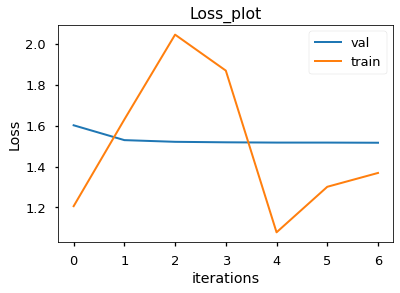

<Figure size 748.8x514.8 with 0 Axes>

/home/leonov/anaconda3/envs/leon_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 336x99502 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 360x360 with 1 Axes>

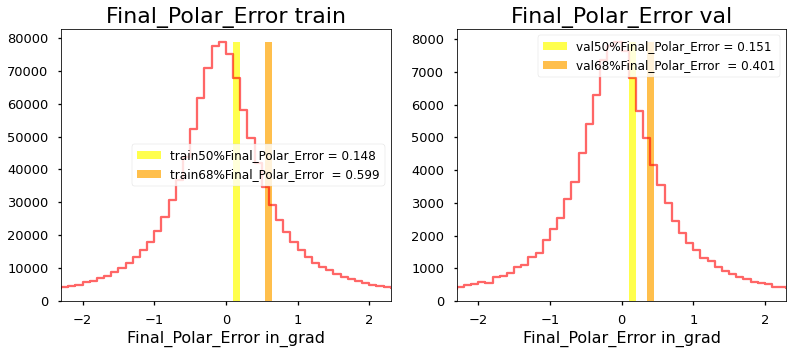

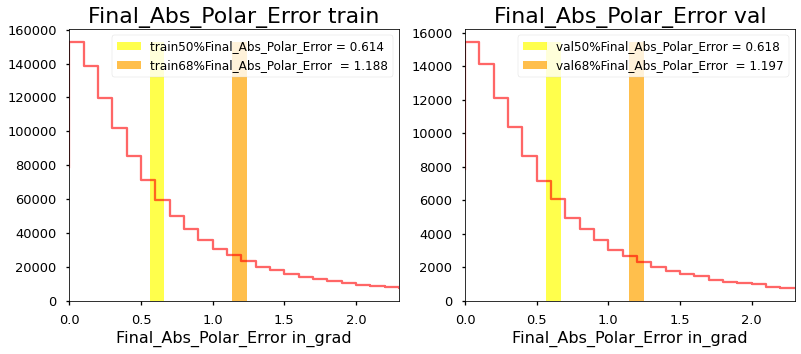

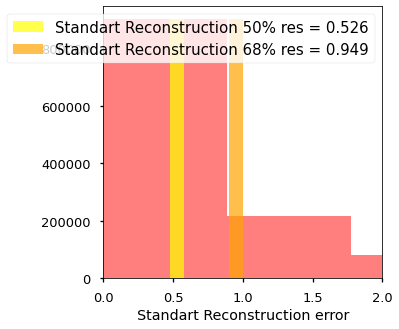

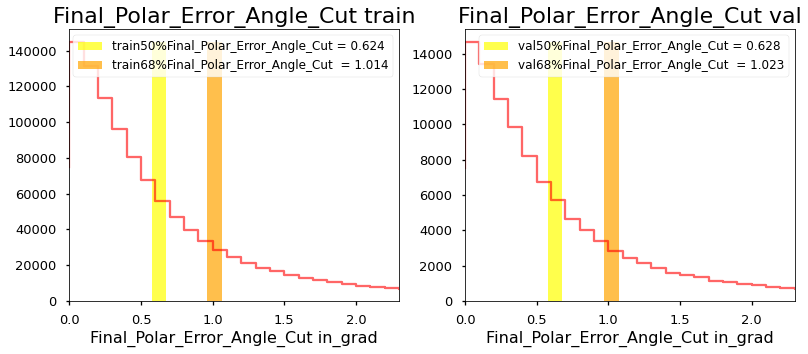

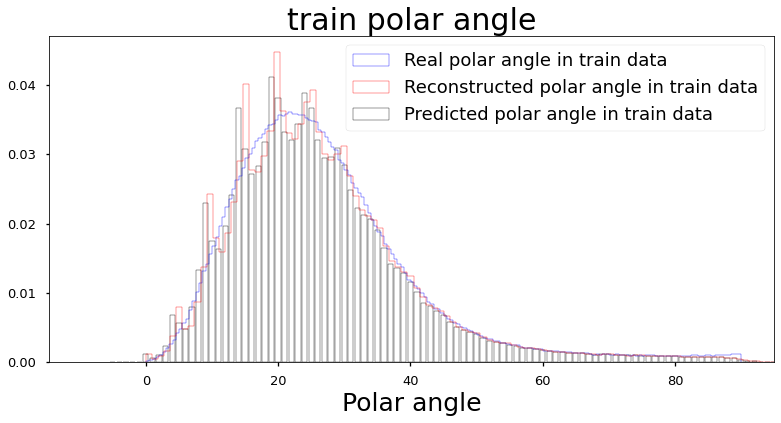

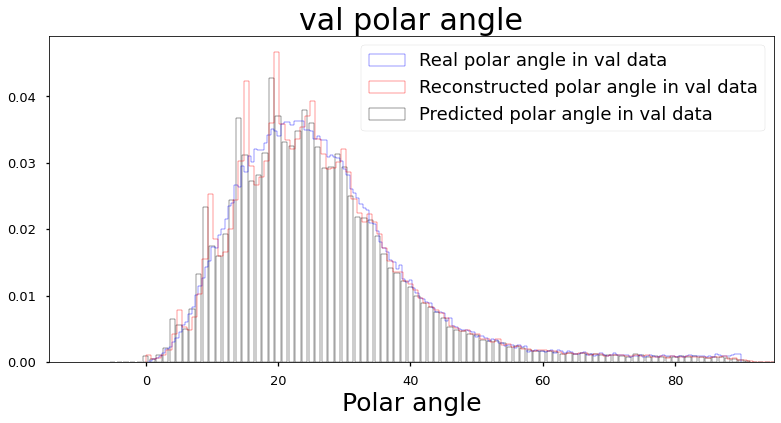

In [10]:
model = net_MC_data_polar.to(device)
opt = torch.optim.Adam(model.parameters(),lr=1e-5)

sch_Exp = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.7)
sch_MultiStep = torch.optim.lr_scheduler.MultiStepLR(opt,milestones=[6,12,18,24,30], gamma=1.0) 
loss_lists, polar_hists ,polar_error =fitting(model, sch_Exp , sch_MultiStep, opt,
                                                                       suffix = "Nu_MAE_only_polar_MC_use_rec",
                                                                       epochs_num = 2, batch_size =64)

# MSE

Num of sub-epochs in Epoch =  26 

Indeed Epoch =  1     Indeed Epoch =  2     Indeed Epoch =  3     Indeed Epoch =  4     Indeed Epoch =  5     Indeed Epoch =  6     Indeed Epoch =  7     Indeed Epoch =  8     Indeed Epoch =  9     Indeed Epoch =  10     Indeed Epoch =  11     Indeed Epoch =  12     Indeed Epoch =  13     Indeed Epoch =  14     Indeed Epoch =  15     

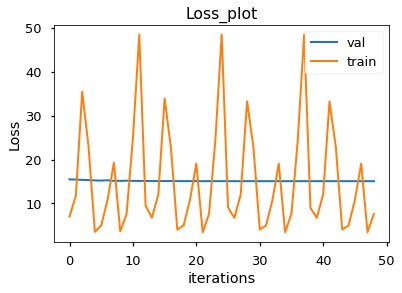

<Figure size 748.8x514.8 with 0 Axes>

/home/leonov/anaconda3/envs/leon_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 336x99502 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 360x360 with 1 Axes>

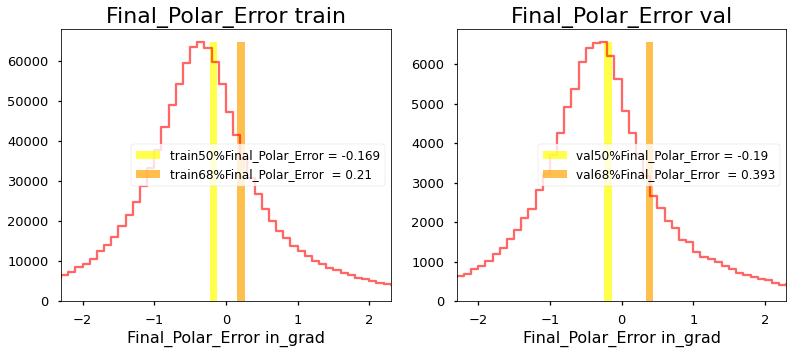

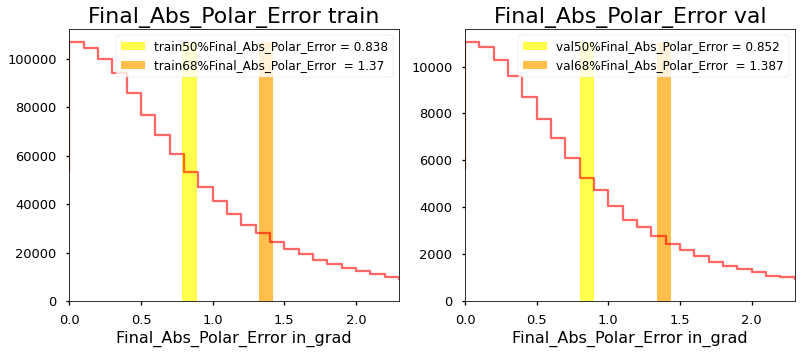

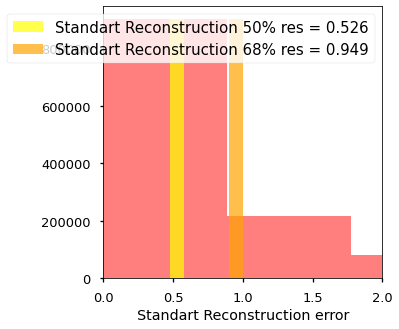

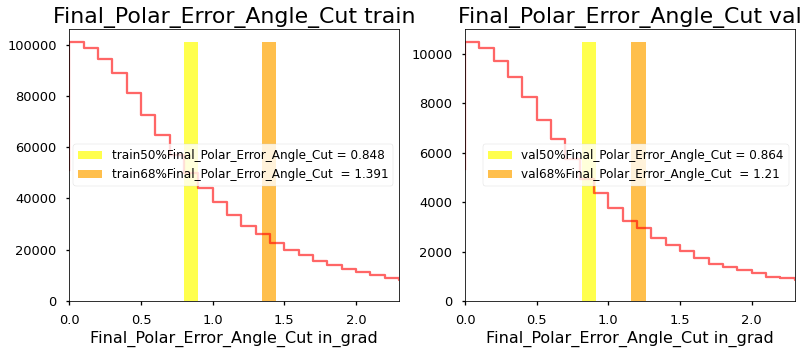

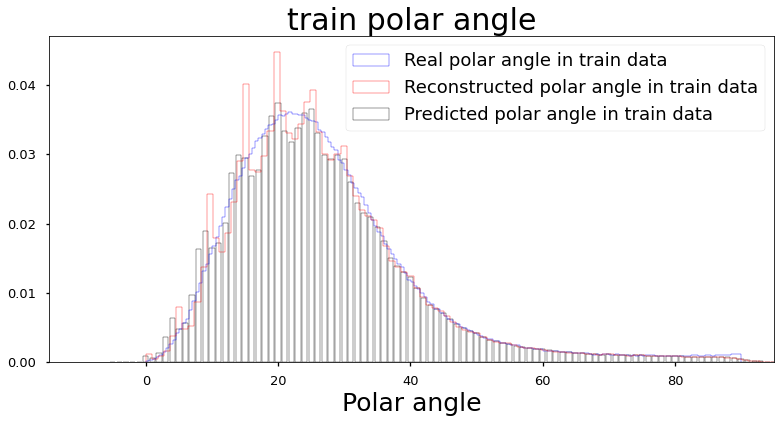

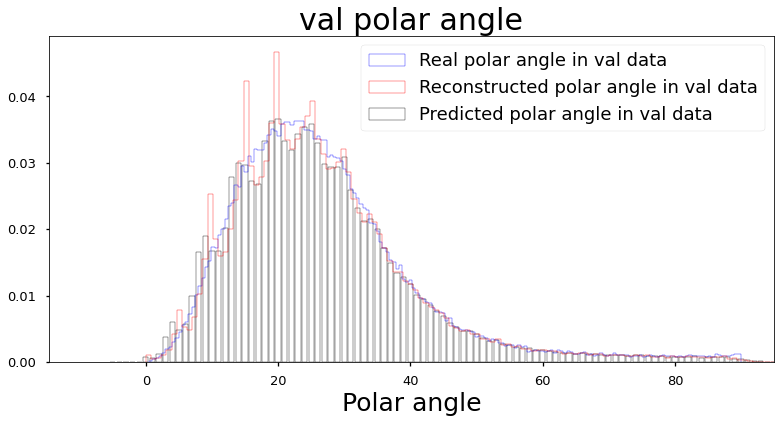

In [8]:

model_MSE = net_MC_data_polar.to(device)
opt_MSE = torch.optim.Adam(model_MSE.parameters(),lr=1e-2)

sch_Exp_MSE = torch.optim.lr_scheduler.ExponentialLR(opt_MSE, gamma=0.5)
sch_MultiStep_MSE = torch.optim.lr_scheduler.MultiStepLR(opt_MSE,milestones=[6,12,18,24,30], gamma=0.9) 
loss_lists, polar_hists ,polar_error =fitting(model_MSE, sch_Exp_MSE , sch_MultiStep_MSE, opt_MSE,
                                              criterion=torch.nn.MSELoss(),
                                                                       suffix = "Nu_MAE_only_polar_MC_use_rec",
                                                                       epochs_num = 15, batch_size =64)